In [1]:
import numpy as np
import matplotlib.pyplot as plt
import msmrd2
import msmrd2.tools.quaternions as quats
import msmrd2.visualization as msmrdvis
from msmrd2.potentials import patchyParticle
from msmrd2.integrators import overdampedLangevin as odLangevin

Failed to import pyEVTK, export2visit functions will not work


In [2]:
# Define arbitrarily large list of rod-like particles
np.random.seed(seed=1) # seed 1 good for pentamer 
numparticles = 5
boxsize = 3
D = 1.0
Drot = 1.0
pyPartlist = [] 
positionList = [np.array([-1.0,0,0]), np.array([0.,0.,0.]), np.array([1.0,0.,0.]), 
                np.array([2.0,0.,0.]), np.array([3.0,0.,0.])]
orientationList = [ np.array([1.,0.,0.,0.]), np.array([np.cos(np.pi/2),0.,0.,np.sin(np.pi/2)])]

"""
# Position List for pentamer IC
th0 = 3*np.pi/5.0
th = np.pi - th0
thextra = np.pi/2 + th/2.0
positionList = []
orientationList = []
for i in range(5):
    positionList.append(0.85*np.array([np.cos(th*i),np.sin(th*i),0.0]))
    orientation = np.array([np.cos(0.5*(th*i + thextra)),0,0,np.sin(0.5*(th*i + thextra))])
    orientationList.append(orientation)
"""

for i in range(numparticles):
    
    overlap = True
    while overlap:
        position = np.array([boxsize*np.random.rand()-0.5*boxsize,
                             boxsize*np.random.rand()-0.5*boxsize,
                             boxsize*np.random.rand()-0.5*boxsize])
        overlap = False     
        for j in range(len(pyPartlist)):
            if np.linalg.norm(position - pyPartlist[j].position) < 2.0:
                overlap = True
                continue
                
    orientation = np.array([np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand()])
    orientation = orientation/np.linalg.norm(orientation)
    #orientation = np.array([1.,0.,0.,0.])
    #orientation = np.array([np.cos(np.pi/4.0), np.sin(np.pi/4), 0.0, 0.0]) #Rotate 90 degrees in x axis
    part = msmrd2.particle(D, Drot, position, orientation)
    #part = msmrd2.particle(D, Drot, positionList[i], orientation)
    #part = msmrd2.particle(D, Drot, positionList[i], orientationList[i])
    pyPartlist.append(part)

In [3]:
# Create list of particles that can be read from msmrd
# Note the particles in this list will be independent from the python list.
partlist = msmrd2.integrators.particleList(pyPartlist)

In [4]:
# Over-damped Langevin integrator definition
dt = 0.00001 #0.000005
seed = 2 # Seed = -1 used random device as seed
bodytype = 'rigidbody'
integrator = odLangevin(dt, seed, bodytype) 
integrator.setKbT(0.1)

In [5]:
# Define boundary (choose either spherical or box)
# sphericalBoundary = msmrd2.sphere(radius,'reflective')
#boxBoundary = msmrd2.box(boxsize,boxsize,boxsize,'reflective')
sphereBoundary = msmrd2.sphere(boxsize,'reflective')
integrator.setBoundary(sphereBoundary)

In [6]:
# Define Patchy Particle potential
sigma = 1.0
strength = 200.0
patch1 = np.array([1.,0.,0.])
patch2 = np.array([np.cos(3*np.pi/5.0),np.sin(3*np.pi/5.0),0.])
#patch2 = np.array([-1.,0.,0.])
patchesCoordinates = [patch1, patch2]
potentialPatchyParticle = patchyParticle(sigma, strength, patchesCoordinates)
integrator.setPairPotential(potentialPatchyParticle)

In [ ]:
# Integrate particle list and print only positions 
timesteps = 5000000
stride = 2500 #1000
datafile  = open('../data/vmd/patchyParticles.xyz', 'w')
for i in range(timesteps):
    if i%stride == 0:
        datafile.write(str(3*len(partlist)) + '\n')
        datafile.write(str(0) + '\n')
    for j, part in enumerate(partlist):
        if i%stride == 0:
            v0 = part.position
            v1 = v0 + 0.6*sigma*quats.rotateVec(patchesCoordinates[0], part.orientation)
            v2 = v0 + 0.6*sigma*quats.rotateVec(patchesCoordinates[1], part.orientation)
            datafile.write('type_0' + ' ' + ' '.join(map(str, v0)) + '\n')
            datafile.write('type_1' + ' ' + ' '.join(map(str, v1)) + '\n')
            datafile.write('type_1' + ' ' + ' '.join(map(str, v2)) + '\n')
    integrator.integrate(partlist)
    if i%5000 == 0:
        print("Percentage complete: ", 100*i/timesteps, "%", end="\r")
datafile.close()
# Generate TCL script to visualize with VMD
msmrdvis.generateTCL_patchyParticles(numparticles = numparticles)
print("Percentage complete: ", 100, " %")

In [7]:
# Calculate potential for aligned and misaligned molecules
def patchyParticlesEvaluate(p1,p2,or1,or2):
    part1 = msmrd2.particle(1.0, 1.0, p1, or1)
    part2 = msmrd2.particle(1.0, 1.0, p2, or2)
    return potentialPatchyParticle.evaluate(part1, part2)

dist = np.arange(0, 2*sigma, 0.01)
pos1 = np.array([0., 0., 0.])
pos2 = np.array([[i, 0., 0.] for i in dist])
phi1 = 0.0
phi2 = np.pi
phi1p = np.pi
phi2p = 0.0
u = np.array([0.,0.,1.]) #rotationAxis
# Quaternions that rotate phi along axis u
theta1 = np.array([np.cos(0.5*phi1 ),
                   np.sin(0.5*phi1 )*u[0],
                   np.sin(0.5*phi1 )*u[1],
                   np.sin(0.5*phi1 )*u[2]]) 
theta2 = np.array([np.cos(0.5*phi2 ),
                   np.sin(0.5*phi2 )*u[0],
                   np.sin(0.5*phi2 )*u[1],
                   np.sin(0.5*phi2 )*u[2]]) 
theta1p = np.array([np.cos(0.5*phi1p ),
                   np.sin(0.5*phi1p )*u[0],
                   np.sin(0.5*phi1p )*u[1],
                   np.sin(0.5*phi1p )*u[2]]) 
theta2p = np.array([np.cos(0.5*phi2p ),
                   np.sin(0.5*phi2p )*u[0],
                   np.sin(0.5*phi2p )*u[1],
                   np.sin(0.5*phi2p )*u[2]]) 

potantialAligned = [patchyParticlesEvaluate(pos1,p2,theta1,theta2) for p2 in pos2]
potantialMisaligned = [patchyParticlesEvaluate(pos1,p2,theta1p,theta2p) for p2 in pos2]

(0, 2.0)

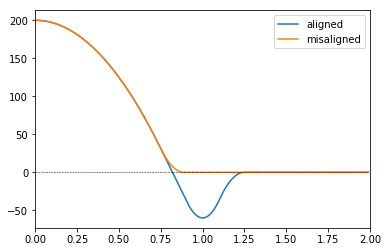

In [8]:
# Plot potential
plt.plot(dist, potantialAligned, label = "aligned")
plt.plot(dist, potantialMisaligned, label = "misaligned")
plt.plot(dist, 0*dist, '--k', lw=0.5)
plt.legend()
plt.xlim([0,2*sigma])

In [ ]:
part1 = msmrd2.particle(1.0, 1.0, pos1, theta1)
part2 = msmrd2.particle(1.0, 1.0, pos2[20], theta2p)
potentialPatchyParticle.forceTorque(part1,part2)

In [ ]:
def U(x, sigma, xstar, xcritical, eps, a, b):
    if (xstar>xcritical):
        raise ValueError('xstar should be smaller than xcritical.')
    resultm2 = np.array([])
    resultm1 = np.array([])
    result0 = np.array([])
    x0 = x[x<0]
    if len(x0) > 0:
        xm2 = x0[x0 < -xcritical]
        resultm2 = 0.0*xm2
        xm1 = x0[x0 >= -xcritical]
        xm1 = xm1[xm1 < -xstar]
        resultm1 = eps*b*(xcritical/sigma + xm1/sigma)**2
        x0 = x0[x0 >= -xstar]
        result0 = eps*(1.0 - a*(x0/sigma)**2)
    x1 = x[x>=0]
    x1 = x1[x1<xstar]
    result1 = eps*(1.0 - a*(x1/sigma)**2)
    x2 = x[x>=xstar]
    x2 = x2[x2<xcritical]
    result2 = eps*b*(xcritical/sigma - x2/sigma)**2
    x3 = x[x>=xcritical]
    result3 = 0.0*x3 
    return np.concatenate((resultm2, resultm1, result0, result1, result2, result3))

In [ ]:
def calculateContinuityParametrs(sigma, xstar, a):
    xcritical = sigma**2/(a*xstar)
    b = (1.0 - a*(xstar/sigma)**2)/(xcritical/sigma - xstar/sigma)**2
    return xcritical, b
def calculateContinuityParametrs2(sigma, xstar, a):
    xcritical = sigma**2/(a*xstar)
    b = -(1.0 - a*(xstar/sigma)**2)/(xcritical/sigma - xstar/sigma)**2
    return xcritical, b

In [ ]:
sigmaRep = 1.0
# Repulsive part
eps = 50.0 #100.0
a = 1.5
xstar = 0.75*sigmaRep
xcritical, b = calculateContinuityParametrs(sigmaRep,xstar,a)
sigma = 1.0
# Attractive patches part
eps2 = -7.5
a2 = 40.0
xstar2 = 0.1*sigma
xcritical2, b2 = calculateContinuityParametrs(sigma,xstar2,a2)
# Isotropic attractive
eps3 = -0.0
a3 = 0.75 # 0.5#0.55
xstar3 = 0.95*sigma
xcritical3, b3 = calculateContinuityParametrs(sigma,xstar3,a3)

In [ ]:
x = np.arange(0,2.0*sigma,0.001)
y1 = U(x, sigmaRep, xstar, xcritical, eps, a, b)
y21 = U(x - sigma, sigma, xstar2, xcritical2, eps2, a2, b2)
y22 = U(x + -0.8*sigma, sigma, xstar2, xcritical2, eps2, a2, b2)
y3 = U(x, sigma, xstar3, xcritical3, eps3, a3, b3)
ym = y1 + y21 + y3
yp = y1 + y22 + y3
plt.plot(x,ym, '-b')
plt.plot(x,yp, '-r')
plt.plot(x, 0*x, '--k', lw=0.5)
plt.xlim([0, 2*sigma])
#plt.ylim([-25.0, 100])


In [ ]:
yy = U(x, sigma, xstar2, xcritical2, eps2, a2, b2)
plt.plot(x,yy, '-b')
